In [34]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


In [2]:
import pandas as pd

file_path = '/content/train.csv'

df = pd.read_csv(file_path)

### **1. Understanding Dataset**

In [ ]:

print("DataFrame Shape (Rows, Columns):", df.shape)

DataFrame Shape (Rows, Columns): (15533, 18)


In [40]:

print("\nData Types (df.info()):")
df.info()


Data Types (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC    

**1.1 Missing values and duplicates**

In [39]:
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()


np.int64(0)

 The dataset is complete as no missing values and duplicate rows were detected, ensuring a clean foundation for analysis and modeling.

In [3]:

print("\nFirst 5 Rows of the DataFrame (df.head()):")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


First 5 Rows of the DataFrame (df.head()):
| id   | Gender   | Age     | Height   | Weight   | family_history_with_overweight   | FAVC   | FCVC    | NCP     | CAEC       | SMOKE   | CH2O    | SCC   | FAF      | TUE      | CALC      | MTRANS                | WeightCategory      |
|:-----|:---------|:--------|:---------|:---------|:---------------------------------|:-------|:--------|:--------|:-----------|:--------|:--------|:------|:---------|:---------|:----------|:----------------------|:--------------------|
| 0    | Male     | 24.443  | 1.7      | 81.67    | yes                              | yes    | 2       | 2.9833  | Sometimes  | no      | 2.76357 | no    | 0        | 0.976473 | Sometimes | Public_Transportation | Overweight_Level_II |
| 1    | Female   | 18      | 1.56     | 57       | yes                              | yes    | 2       | 3       | Frequently | no      | 2       | no    | 1        | 1        | no        | Automobile            | Normal_Weight       |
| 2    |

**1.2 Variable Identification**

In [3]:
# Target is 'WeightCategory'
TARGET_VARIABLE = 'WeightCategory'
FEATURE_VARIABLES = df.columns.drop(['id', TARGET_VARIABLE]).tolist()

print("\n--- Variable Identification ---")
print(f"Target Variable: {TARGET_VARIABLE}")
print(f"Feature Variables (excluding 'id'): {len(FEATURE_VARIABLES)} columns")


--- Variable Identification ---
Target Variable: WeightCategory
Feature Variables (excluding 'id'): 16 columns


**1.3 Target Class Distribution**

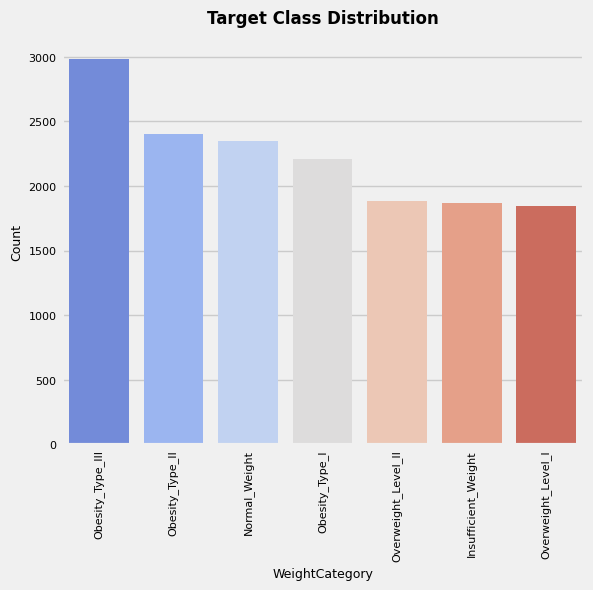

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

categories = df['WeightCategory'].value_counts().index
colors = sns.color_palette("coolwarm", len(categories))

plt.figure(figsize=(6, 5))
sns.countplot(
    x='WeightCategory',
    hue='WeightCategory',
    data=df,
    order=categories,
    palette=dict(zip(categories, colors))
)

plt.title('Target Class Distribution', fontsize=12, fontweight='bold', y=1.02)
plt.xticks(rotation=90)
plt.xlabel('WeightCategory', fontsize=9)
plt.ylabel('Count', fontsize=9)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

### **2. Exploratory Data Analysis**

**2.1 Feature Analysis**

In [4]:
# explicitly list the numericals and categoricals (excluding 'id' and 'WeightCategory')
df_temp = df.drop(columns=['id', TARGET_VARIABLE], errors='ignore')
numerical_cols = df_temp.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df_temp.select_dtypes(include=['object']).columns.tolist()

In [11]:
from tabulate import tabulate
import pandas as pd

# Create a DataFrame with aligned columns
max_len = max(len(numerical_cols), len(categorical_cols))
numerical_cols += [''] * (max_len - len(numerical_cols))
categorical_cols += [''] * (max_len - len(categorical_cols))

table_df = pd.DataFrame({
    'Numerical Columns': numerical_cols,
    'Categorical Columns': categorical_cols
})

# Print as formatted table
print(tabulate(table_df, headers='keys', tablefmt='grid'))

+----+---------------------+--------------------------------+
|    | Numerical Columns   | Categorical Columns            |
+====+=====================+================================+
|  0 | Age                 | Gender                         |
+----+---------------------+--------------------------------+
|  1 | Height              | family_history_with_overweight |
+----+---------------------+--------------------------------+
|  2 | Weight              | FAVC                           |
+----+---------------------+--------------------------------+
|  3 | FCVC                | CAEC                           |
+----+---------------------+--------------------------------+
|  4 | NCP                 | SMOKE                          |
+----+---------------------+--------------------------------+
|  5 | CH2O                | SCC                            |
+----+---------------------+--------------------------------+
|  6 | FAF                 | CALC                           |
+----+--

**2.2 Numerical Feature Analysis**

**2.2.1 Descriptive Stats**

In [58]:

print("\n\n" + "="*80)
print("                          Descriptive Statistics")
print("="*80)

# Calculate and print descriptive statistics, transposed for better readability
numerical_stats = df[numerical_cols].describe().T
print(numerical_stats.to_markdown(numalign="left", stralign="left"))




                          Descriptive Statistics
|        | count   | mean     | std      | min   | 25%     | 50%      | 75%     | max     |
|:-------|:--------|:---------|:---------|:------|:--------|:---------|:--------|:--------|
| Age    | 15533   | 23.8163  | 5.66317  | 14    | 20      | 22.7716  | 26      | 61      |
| Height | 15533   | 1.69992  | 0.08767  | 1.45  | 1.63093 | 1.7      | 1.76292 | 1.97566 |
| Weight | 15533   | 87.7852  | 26.3691  | 39    | 66      | 84       | 111.601 | 165.057 |
| FCVC   | 15533   | 2.44292  | 0.530895 | 1     | 2       | 2.34222  | 3       | 3       |
| NCP    | 15533   | 2.76042  | 0.706463 | 1     | 3       | 3        | 3       | 4       |
| CH2O   | 15533   | 2.02763  | 0.607733 | 1     | 1.79626 | 2        | 2.53146 | 3       |
| FAF    | 15533   | 0.976968 | 0.836841 | 0     | 0.00705 | 1        | 1.58268 | 3       |
| TUE    | 15533   | 0.613813 | 0.602223 | 0     | 0       | 0.566353 | 1       | 2       |


**2.2.2 Univariate Analysis**

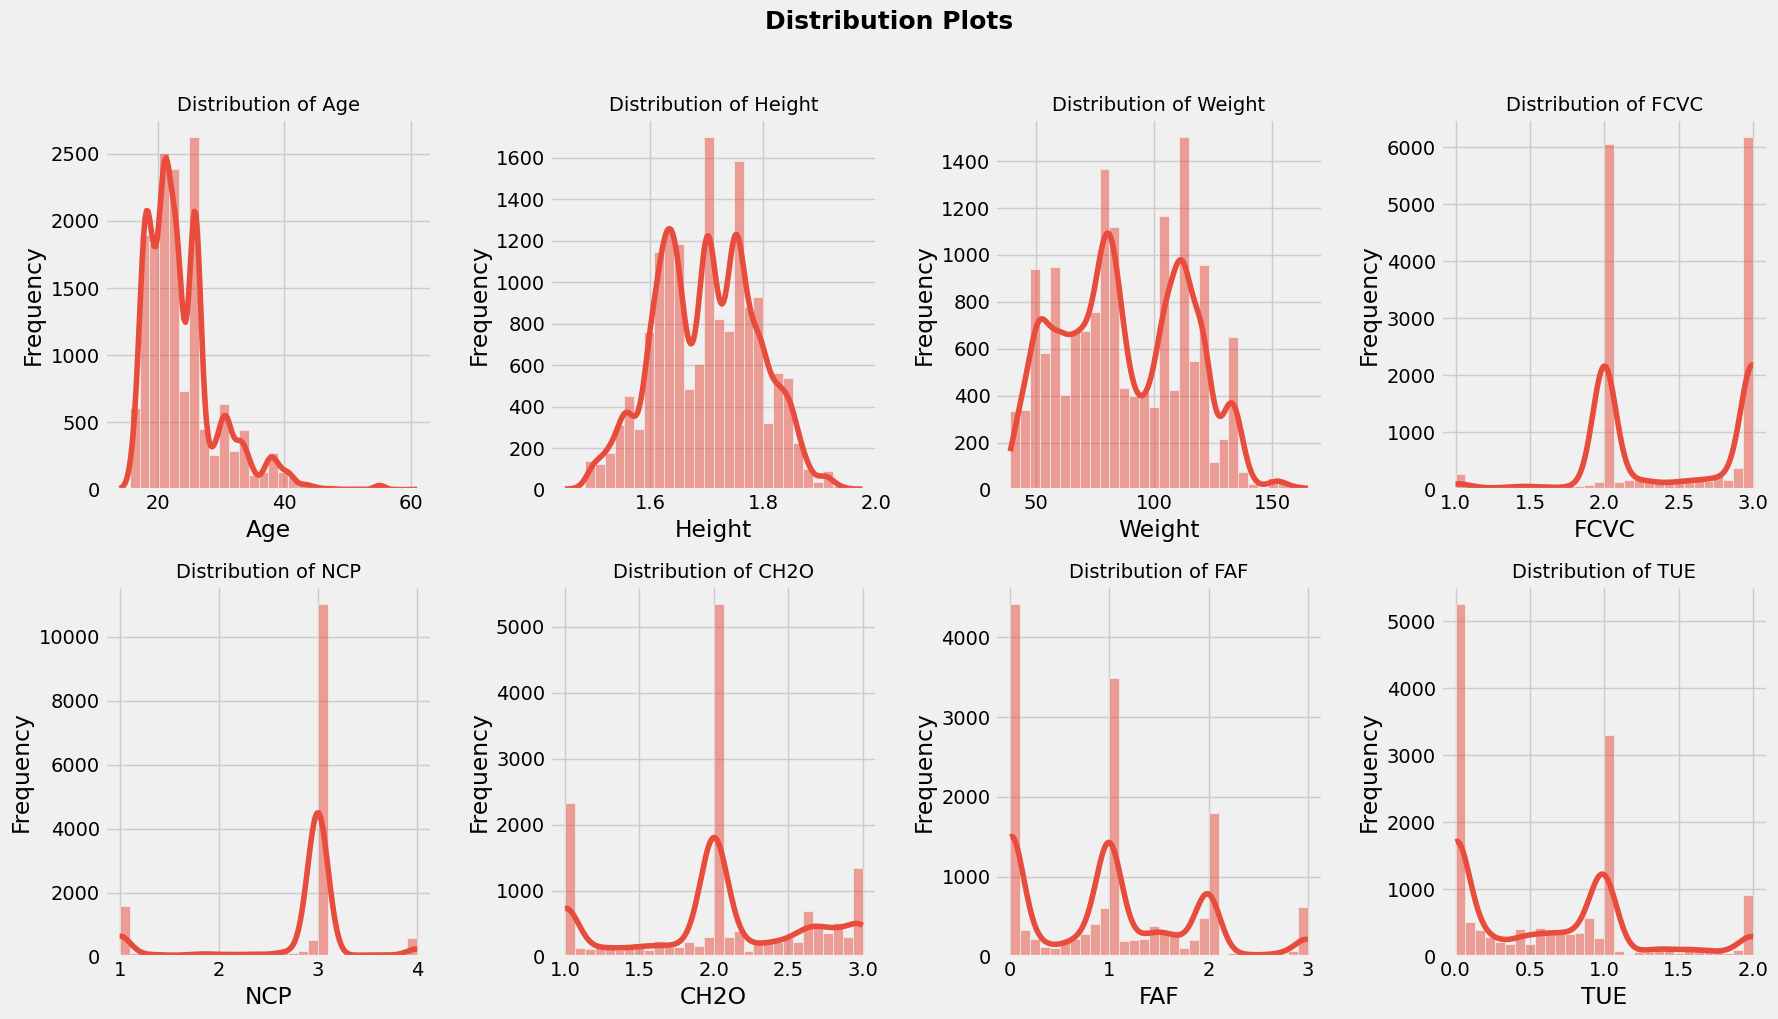

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

n_cols = 4
n_rows = -(-len(numerical_cols) // n_cols)  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(df[col], kde=True, bins=30, ax=ax, color='#e74c3c')
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution Plots", fontsize=18, fontweight='bold', y=1.02)  # Add figure-level title
plt.tight_layout()
plt.show()

The numerical features exhibit diverse distributions—some are symmetric (e.g., Height, CH2O), while others show skewness or multimodality (e.g., Age, FAF), indicating varied behavioral and physiological patterns across the dataset.

**2.2.3 Bivariate Analysis**

**2.2.3.2 Numerical Feature Distribution vs WeightCategory**

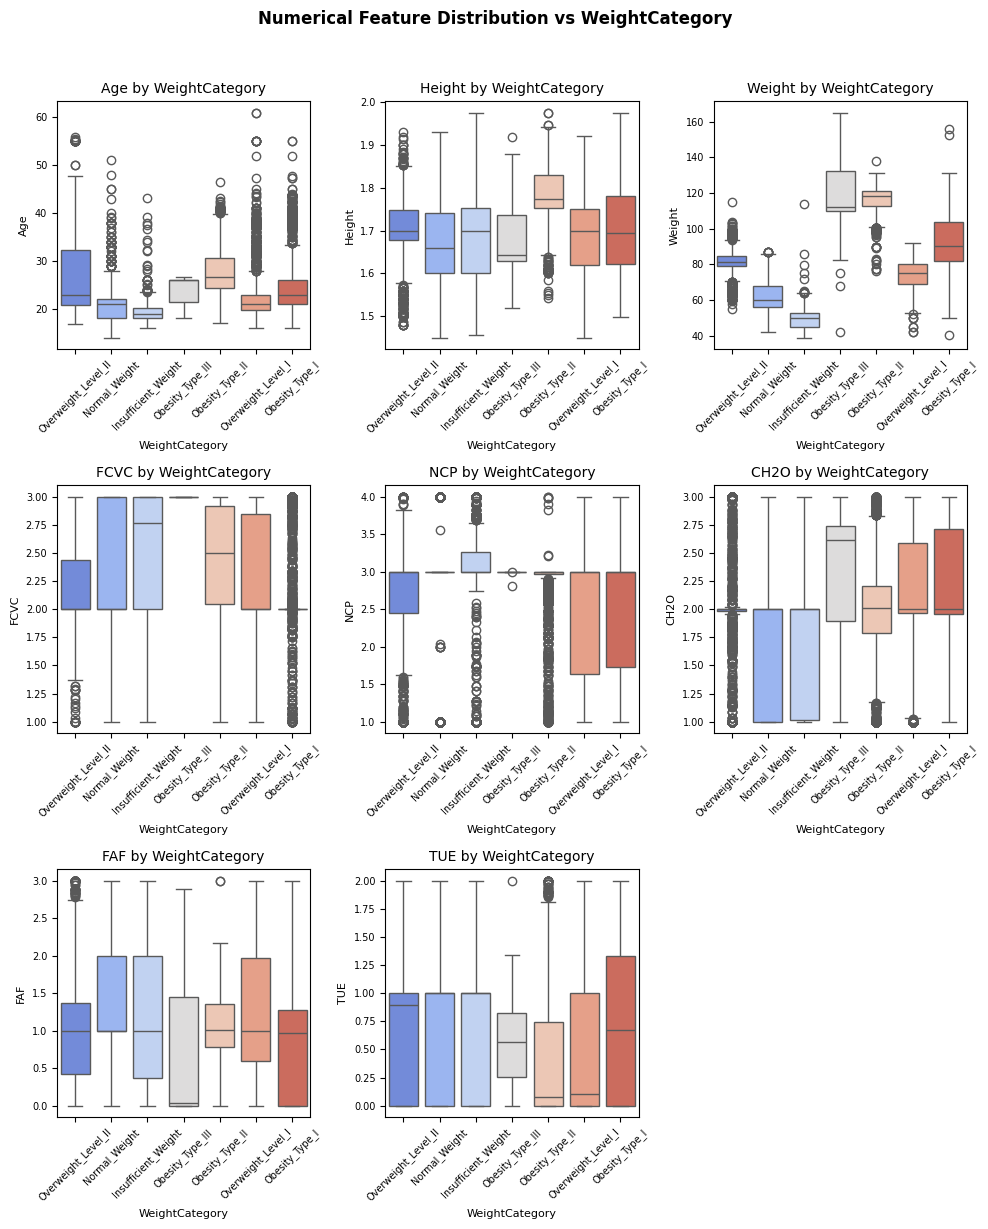

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

target = 'WeightCategory'

numerical_cols = df.select_dtypes(include='number').drop(columns=['id']).columns

n_cols = 3
n_rows = -(-len(numerical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4* n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[target], y=df[col], ax=axes[i], hue=df[target], palette='coolwarm', dodge=False)
    axes[i].set_title(f'{col} by {target}', fontsize=10)
    axes[i].set_xlabel(target, fontsize=8)
    axes[i].set_ylabel(col, fontsize=8)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Feature Distribution vs WeightCategory", fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The heatmap reveals moderate correlations among lifestyle and biometric variables, with notable links like Height–Weight and FCVC–NCP, aiding feature selection and pattern discovery.

**2.3 Categorical Feature Analysis**

**2.3.1 Univariate Analysis**

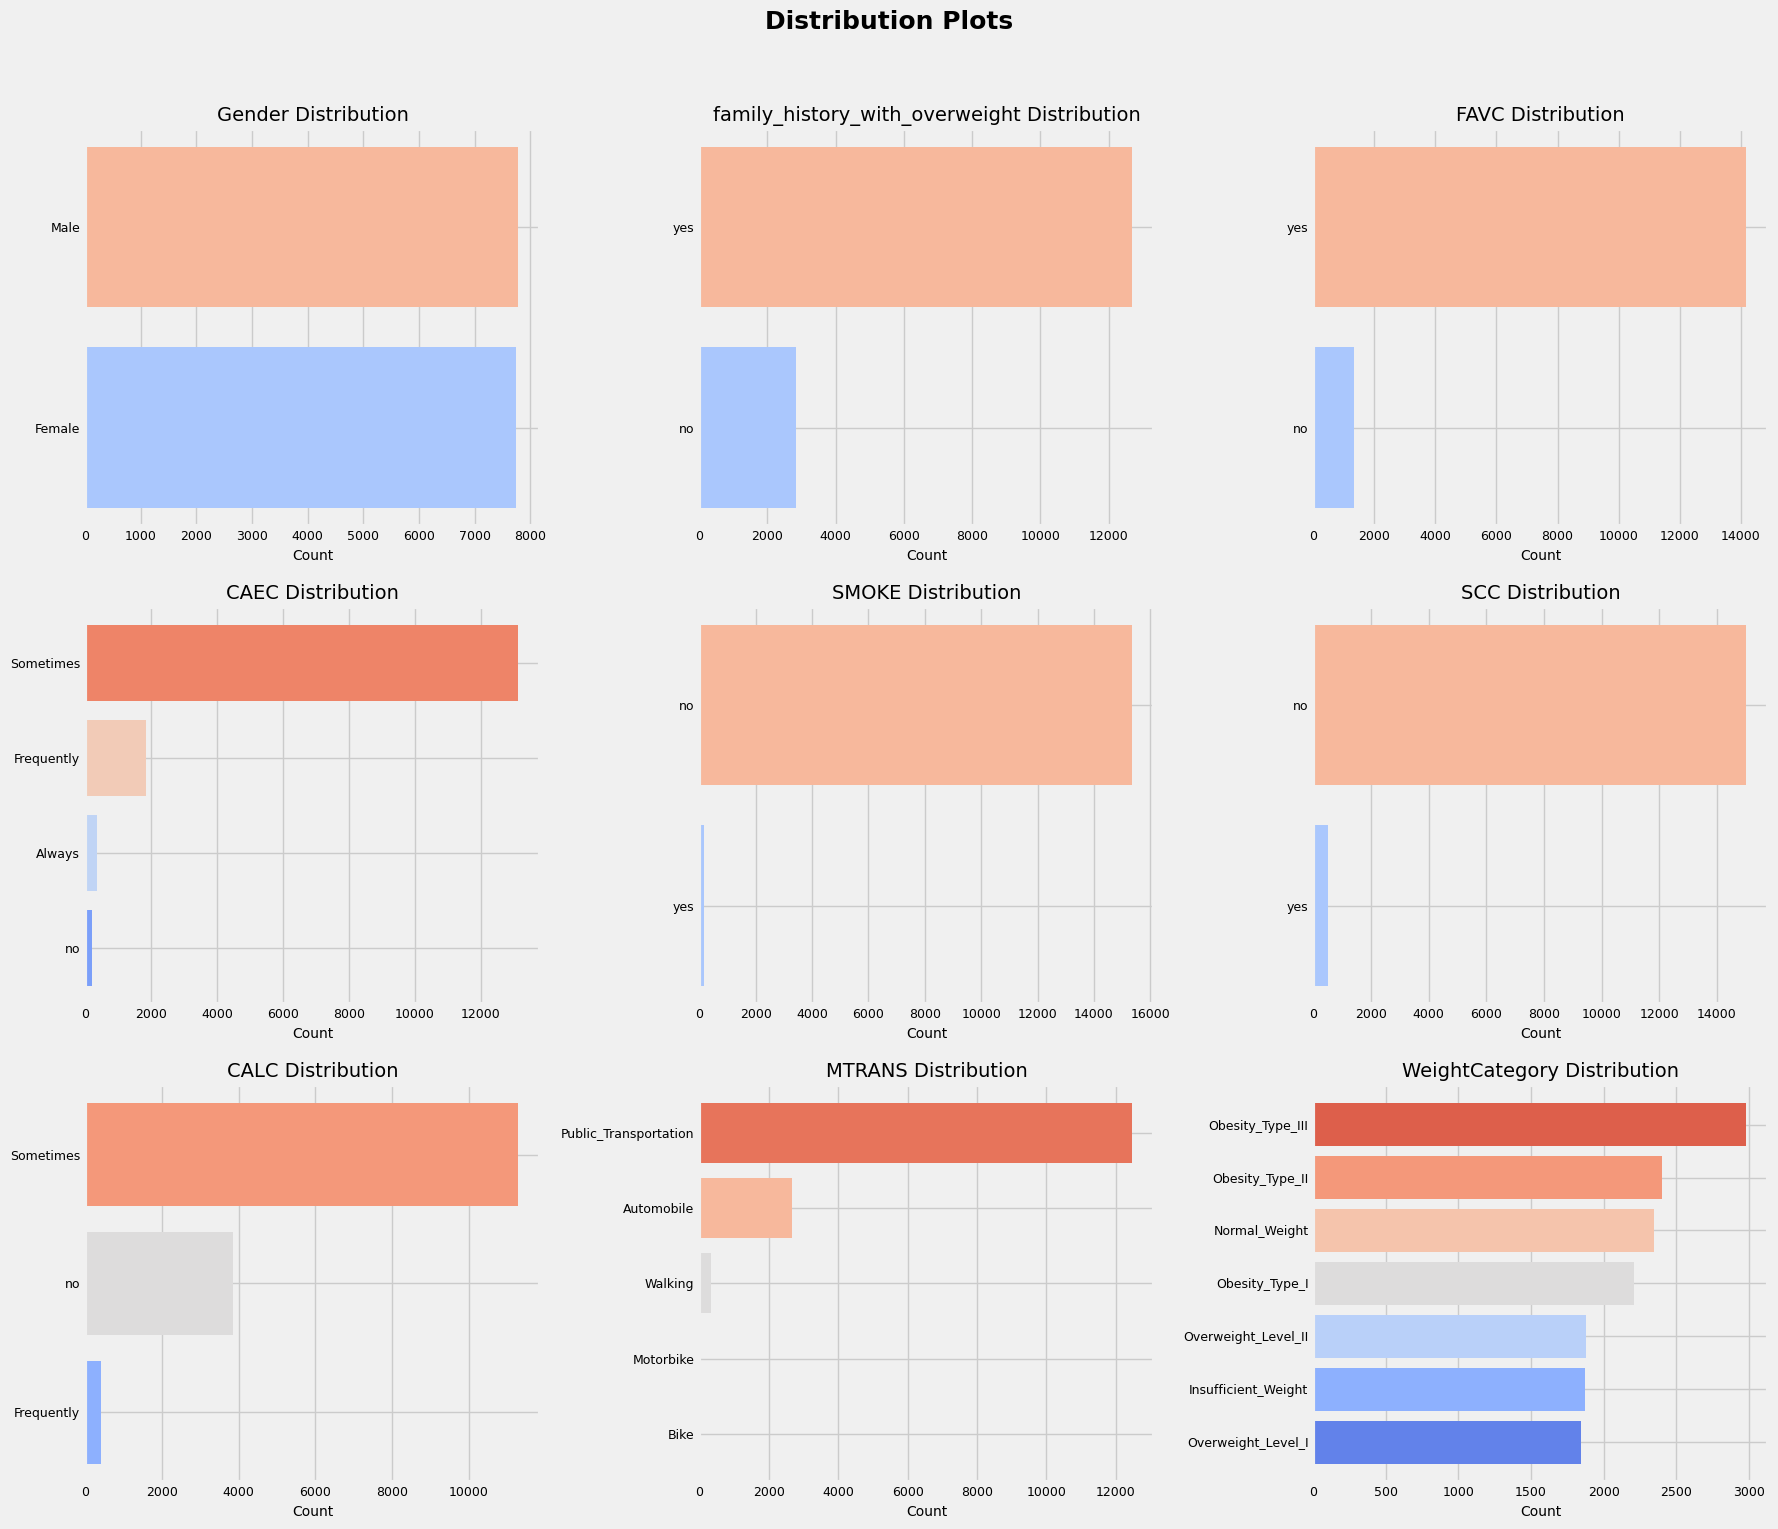

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include='object').columns

n_cols = 3
n_rows = -(-len(categorical_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    counts = df[col].value_counts()
    labels = counts.index
    values = counts.values

    # Generate coolwarm shades based on number of categories
    bar_colors = sns.color_palette("coolwarm", len(labels))[::-1]

    # Horizontal bar plot
    ax.barh(labels, values, color=bar_colors)
    ax.set_title(f'{col} Distribution', fontsize=14)
    ax.set_xlabel('Count', fontsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.invert_yaxis()  # Highest count on top

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution Plots", fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**2.3.2 Bivariate Analysis**

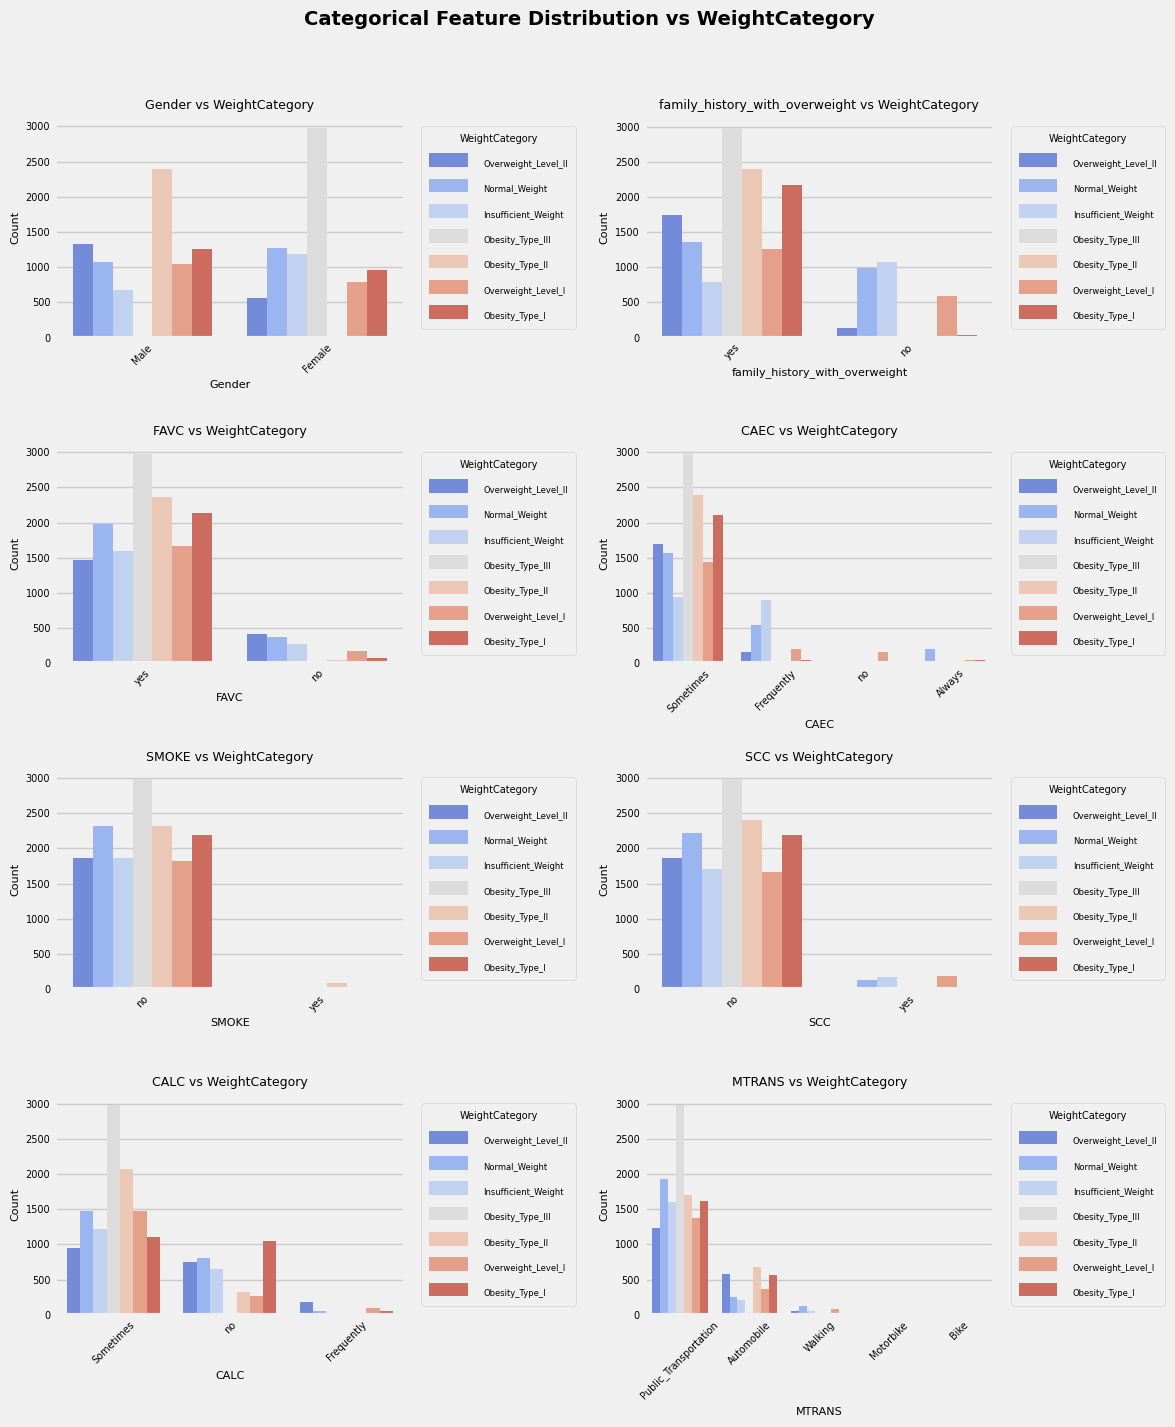

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your categorical target
target = 'WeightCategory'

# Select all categorical columns except the target
categorical_cols = df.select_dtypes(include='object').drop(columns=[target]).columns

# Layout: 2 plots per row
n_cols = 2
n_rows = -(-len(categorical_cols) // n_cols)  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows))  # Smaller figure size
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue=target, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'{col} vs {target}', fontsize=9)  # Reduced title font size
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Count', fontsize=8)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)

    # Move legend to the right and shrink font
    legend = axes[i].legend(title=target, loc='center left', bbox_to_anchor=(1.02, 0.5))
    legend.set_title(target, prop={'size': 7})
    for text in legend.get_texts():
        text.set_fontsize(6)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Categorical Feature Distribution vs WeightCategory", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

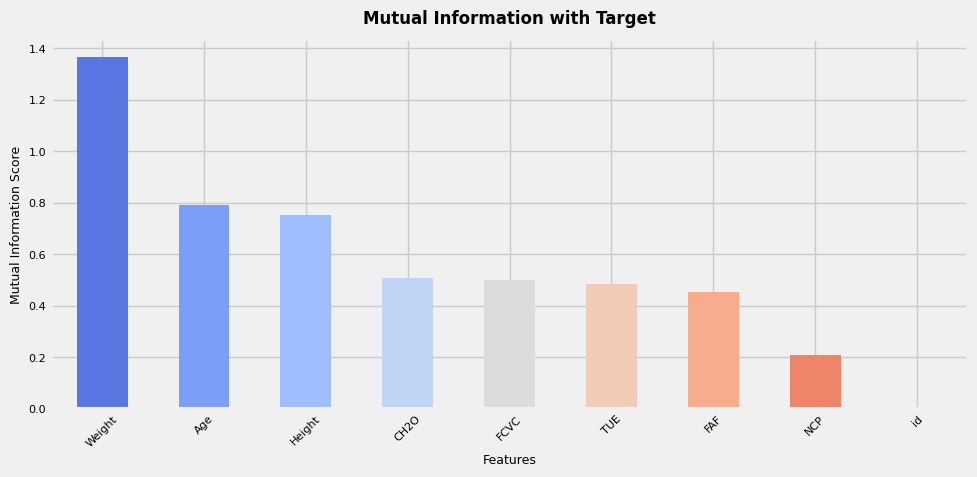

In [152]:
#Mutual Information with Target
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection
X = df.drop('WeightCategory', axis=1)
y = df['WeightCategory']
mi = mutual_info_classif(X.select_dtypes('number'), y)

# Create Series and sort
mi_df = pd.Series(mi, index=X.select_dtypes('number').columns).sort_values(ascending=False)

# Generate coolwarm color palette
colors = sns.color_palette("coolwarm", len(mi_df))

# Plot with reduced font sizes
ax = mi_df.plot.bar(
    figsize=(10, 5),
    color=colors
)
ax.set_xlabel("Features", fontsize=9)
ax.set_ylabel("Mutual Information Score", fontsize=9)
ax.tick_params(axis='x', labelsize=8, rotation=45)
ax.tick_params(axis='y', labelsize=8)
plt.title("Mutual Information with Target",fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**2.4 Correlation Heatmap**

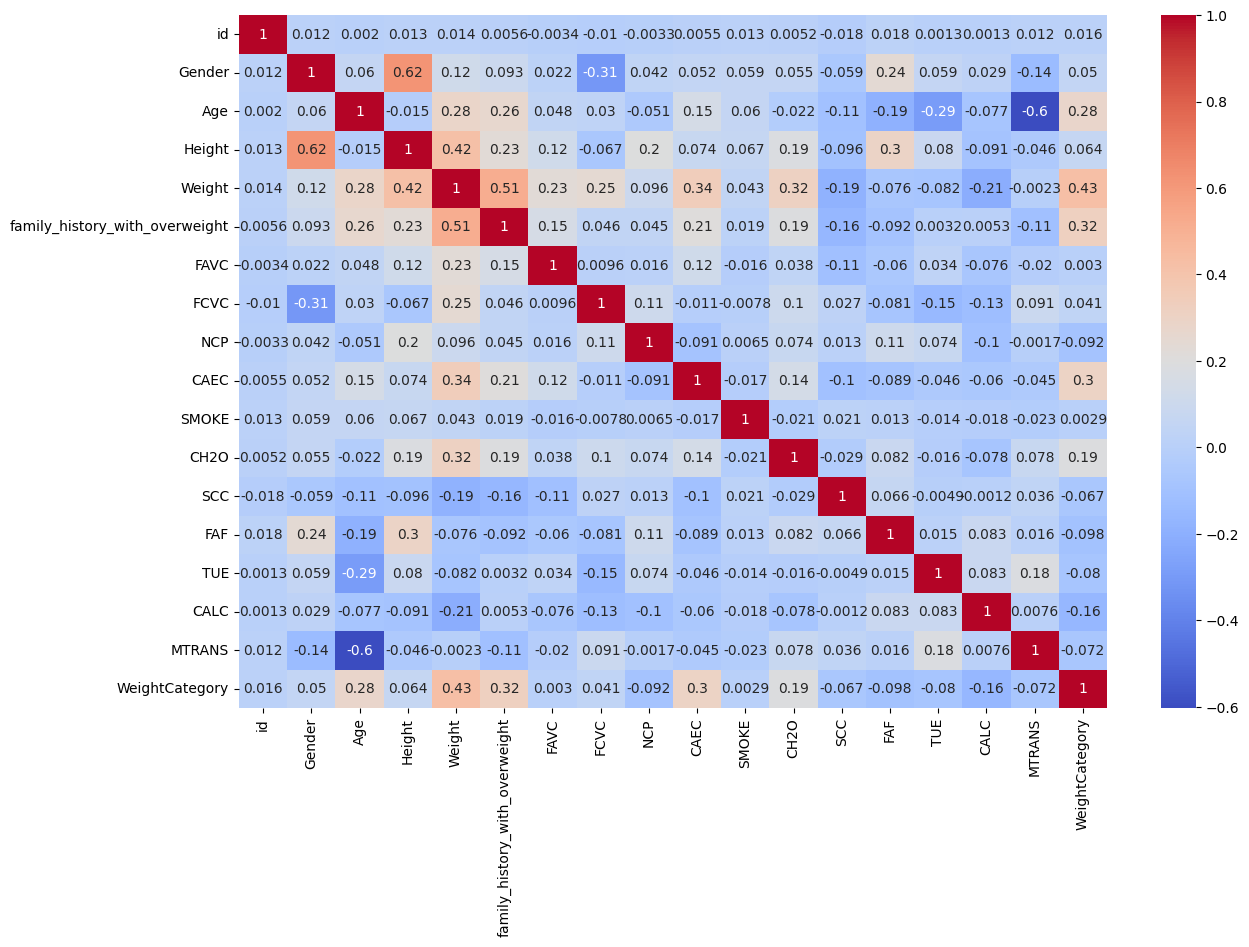

In [23]:
df_copy = df.copy()
categorical_cols = df_copy.select_dtypes(include='object').columns

for col in categorical_cols:
    df_copy[col] = LabelEncoder().fit_transform(df_copy[col])

plt.figure(figsize=(14,9))
sns.heatmap(df_copy.corr(), annot=True, cmap='coolwarm')
plt.show()

**2.5 Outlier Analysis**

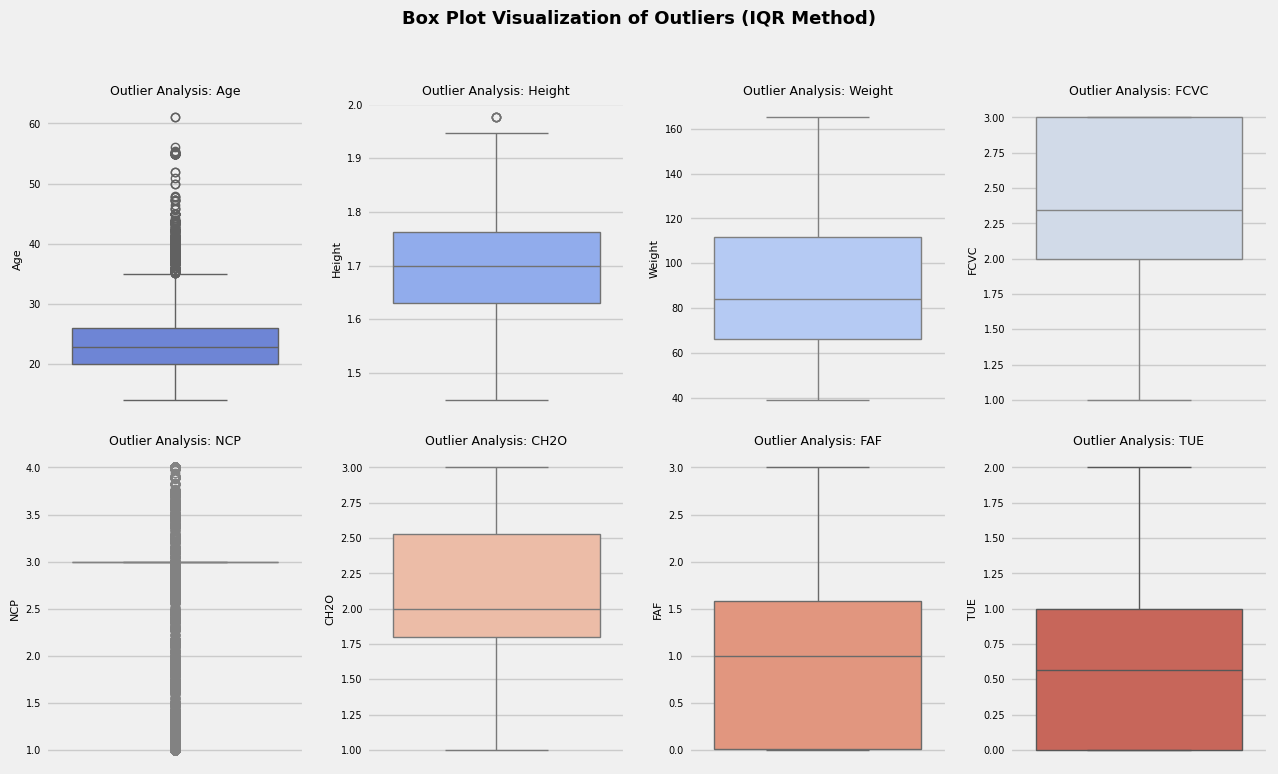

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop 'id' column if present
df_clean = df.drop(columns=['id'], errors='ignore')

# Select numerical columns
numerical_cols = df_clean.select_dtypes(include='number').columns

# Layout: 2 rows max
n_rows = min(2, -(-len(numerical_cols) // 2))  # Max 2 rows
n_cols = -(-len(numerical_cols) // n_rows)     # Adjust columns accordingly

# Generate color palette
colors = sns.color_palette("coolwarm", len(numerical_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, 3.8 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df_clean[col], ax=axes[i], color=colors[i])
    axes[i].set_title(f'Outlier Analysis: {col}', fontsize=9)
    axes[i].set_ylabel(col, fontsize=8)
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].tick_params(axis='x', labelsize=7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Box Plot Visualization of Outliers (IQR Method)", fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

The box plots reveal that Age, FAF, and TUE have significant outliers and skewed distributions, suggesting the need for transformation. In contrast, features like FCVC and CH2O are tightly clustered, indicating consistent behavior across individuals.

### **3. Data Preprocessing**

In [12]:
df.isnull().any()

,0
id,False
Gender,False
Age,False
Height,False
Weight,False
family_history_with_overweight,False
FAVC,False
FCVC,False
NCP,False
CAEC,False


In [13]:
df.duplicated().any()

np.False_

In [14]:
x=df.drop('WeightCategory',axis=1)
target=df["WeightCategory"]
target.head()

,WeightCategory
0,Overweight_Level_II
1,Normal_Weight
2,Insufficient_Weight
3,Obesity_Type_III
4,Overweight_Level_II


In [15]:
numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = x.select_dtypes(include=['object', 'category']).columns.tolist()
from sklearn.preprocessing import OneHotEncoder
X_encoded = pd.get_dummies(x, drop_first=True)  # simple one-hot encoding

**Loading Dataset**

In [16]:
trainData = pd.read_csv("/content/train.csv")
testData = pd.read_csv("/content/test.csv")

X = trainData.drop(columns=['WeightCategory', 'id'])
y = trainData['WeightCategory']

X_test = testData.drop(columns=['id'])

In [24]:
cat_cols = ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','CALC','MTRANS']
le = LabelEncoder()
for col in cat_cols:
    x[col] = le.fit_transform(x[col])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**Decision Tree**

In [29]:
dt_clf = DecisionTreeClassifier(random_state=42)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

dt_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

dt_clf.fit(X_train, y_train)

y_pred = dt_clf.predict(X_test)

test_accuracy_dtt = accuracy_score(y_test, y_pred)
test_precision_dtt = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_dtt = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_dtt = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("--- Decision Tree Model Evaluation ---")
print("Test Accuracy:", test_accuracy_dtt)
print("Test Precision (Weighted):", test_precision_dtt)
print("Test Recall (Weighted):", test_recall_dtt)
print("Test F1-Score (Weighted):", test_f1_dtt)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


importances = dt_clf.feature_importances_

feature_names = X_train.columns

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importances.to_string(index=False))


--- Decision Tree Model Evaluation ---
Test Accuracy: 0.8651432249758609
Test Precision (Weighted): 0.8659294193764477
Test Recall (Weighted): 0.8651432249758609
Test F1-Score (Weighted): 0.8654772440534064

Confusion Matrix:
 [[307  36   1   1   0   0   1]
 [ 29 413   1   0   0  50   3]
 [  0   0 393  15   1  10  29]
 [  0   0  26 436   0   0   2]
 [  0   0   3   1 602   0   0]
 [  3  49   8   0   0 268  56]
 [  0   6  27   1   0  60 269]]

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.91      0.89      0.90       346
      Normal_Weight       0.82      0.83      0.83       496
     Obesity_Type_I       0.86      0.88      0.87       448
    Obesity_Type_II       0.96      0.94      0.95       464
   Obesity_Type_III       1.00      0.99      1.00       606
 Overweight_Level_I       0.69      0.70      0.69       384
Overweight_Level_II       0.75      0.74      0.74       363

           accuracy                     

Accuracy with decision tree is 0.8651432249758609

**Hyperparameter Tuning Using Optuna on Decision Tree**

In [31]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 5.5 MB/s eta 0:00:00


In [36]:
import optuna

def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    dt_clf = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    score = cross_val_score(dt_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
dt_clf_best = DecisionTreeClassifier(**best_params, random_state=42)
dt_clf_best.fit(X_train, y_train)
y_pred = dt_clf_best.predict(X_test)

test_accuracy_dtt_hp = accuracy_score(y_test, y_pred)
test_precision_dtt_hp = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_dtt_hp = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_dtt_hp = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
print("--- Decision Tree Model Evaluation (Optimized) ---")
print("Test Accuracy:", test_accuracy_dtt_hp)
print("Test Precision (Weighted):", test_precision_dtt_hp)
print("Test Recall (Weighted):", test_recall_dtt_hp)
print("Test F1-Score (Weighted):", test_f1_dtt_hp)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = dt_clf_best.feature_importances_
feature_names = X_train.columns
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(feat_importances.to_string(index=False))


[I 2025-10-26 17:33:59,314] A new study created in memory with name: no-name-bb46715e-0315-49b2-89bd-7321f97bfadf


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-26 17:33:59,811] Trial 0 finished with value: 0.7259775547897198 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7259775547897198.
[I 2025-10-26 17:34:00,673] Trial 1 finished with value: 0.8541765152459406 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8541765152459406.
[I 2025-10-26 17:34:01,015] Trial 2 finished with value: 0.5964914830900123 and parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8541765152459406.
[I 2025-10-26 17:34:01,896] Trial 3 finished with value: 0.8699502890229551 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8699502890229551.
[I 2025-10-26 17:34:02,725] Trial 4 finished with value: 0.865202218945208 and parameters

Accuracy with decision tree using optuna is 0.8651432249758609

**Random Forest**

In [37]:

rf_clf = RandomForestClassifier(
    n_estimators=200,
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

test_accuracy_rf = accuracy_score(y_test, y_pred)
test_precision_rf = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_rf = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_rf = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("--- Random Forest Model Evaluation ---")
print("Test Accuracy:", test_accuracy_rf)
print("Test Precision (Weighted):", test_precision_rf)
print("Test Recall (Weighted):", test_recall_rf)
print("Test F1-Score (Weighted):", test_f1_rf)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = rf_clf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(feat_importances.to_string(index=False))

--- Random Forest Model Evaluation ---
Test Accuracy: 0.8918570968780174
Test Precision (Weighted): 0.8934727995317859
Test Recall (Weighted): 0.8918570968780174
Test F1-Score (Weighted): 0.891523274112166

Confusion Matrix:
 [[308  35   0   1   0   1   1]
 [ 19 441   1   0   0  28   7]
 [  0   1 395  13   1  10  28]
 [  0   0  12 449   0   0   3]
 [  0   0   1   1 603   1   0]
 [  2  51   8   0   0 267  56]
 [  0  12  20   1   0  22 308]]

Classification Report:
                      precision    recall  f1-score   support

Insufficient_Weight       0.94      0.89      0.91       346
      Normal_Weight       0.82      0.89      0.85       496
     Obesity_Type_I       0.90      0.88      0.89       448
    Obesity_Type_II       0.97      0.97      0.97       464
   Obesity_Type_III       1.00      1.00      1.00       606
 Overweight_Level_I       0.81      0.70      0.75       384
Overweight_Level_II       0.76      0.85      0.80       363

           accuracy                      

The accuracy from Random Forest is 0.8918570968780174

**Hyperparameter Tuning Using Optuna On Random Forest**

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])

    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
rf_clf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_clf_best.fit(X_train, y_train)
y_pred = rf_clf_best.predict(X_test)

test_accuracy_rf_hp = accuracy_score(y_test, y_pred)
test_precision_rf_hp = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_rf_hp = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_rf_hp = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
print("--- Random Forest Model Evaluation (Optimized) ---")
print("Test Accuracy:", test_accuracy_rf_hp)
print("Test Precision (Weighted):", test_precision_rf_hp)
print("Test Recall (Weighted):", test_recall_rf_hp)
print("Test F1-Score (Weighted):", test_f1_rf_hp)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = rf_clf_best.feature_importances_
feature_names = X_train.columns
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance from Optimized Random Forest")
plt.show()


The accuracy from Random Forest using optuna is 0.8999034438364982

**GRADIENT BOOSTING**

In [ ]:
gb_clf = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)

test_accuracy_gb = accuracy_score(y_test, y_pred)
test_precision_gb = precision_score(y_test, y_pred, average='weighted', zero_division=0)
test_recall_gb = recall_score(y_test, y_pred, average='weighted', zero_division=0)
test_f1_gb = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("--- Gradient Boosting Model Evaluation ---")
print("Test Accuracy:", test_accuracy_gb)
print("Test Precision (Weighted):", test_precision_gb)
print("Test Recall (Weighted):", test_recall_gb)
print("Test F1-Score (Weighted):", test_f1_gb)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

importances = gb_clf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance from Gradient Boosting")
plt.show()

The accuracy using Gradient Boosting is 0.8979723205664628

In [38]:
pip install xgboost

**XGBOOST**

In [ ]:
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    x, y_enc, test_size=0.2, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_clf.fit(X_train, y_train)

y_pred_enc = xgb_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_xgb = accuracy_score(y_test_orig, y_pred)
test_precision_xgb = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_xgb = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_xgb = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("--- XGBoost Model Evaluation ---")
print("Test Accuracy:", test_accuracy_xgb)
print("Test Precision (Weighted):", test_precision_xgb)
print("Test Recall (Weighted):", test_recall_xgb)
print("Test F1-Score (Weighted):", test_f1_xgb)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))

importances = xgb_clf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10,6))
plt.barh(feat_importances['Feature'], feat_importances['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance from XGBoost")
plt.show()

The accuracy using xgboost is 0.9034438364982298

**Hyperparameter Tuning Using Optuna On XGBoost**

In [ ]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Separate features and target
X = train_df.drop('WeightCategory', axis=1)
y = train_df['WeightCategory']

# Drop ID if present
if 'id' in X.columns:
    X = X.drop('id', axis=1)

test_ids = test_df['id'] if 'id' in test_df.columns else None
test_features = test_df.drop('id', axis=1, errors='ignore')


le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

# Label encode categorical columns for both train and test
X_encoded = X.copy()
test_encoded = test_features.copy()

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    test_encoded[col] = le.transform(test_encoded[col])  # same encoder on test

# Split data for evaluation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_encoded, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

print(f"✅ Training samples: {X_train.shape[0]} | Features: {X_train.shape[1]}")

base_params_list = [
   {'n_estimators': 802, 'learning_rate': 0.01376727840442897, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7294665487567288, 'colsample_bytree': 0.5546856654158943, 'gamma': 0.16215372378274814, 'reg_alpha': 0.1275266644210375, 'reg_lambda': 1.6207767848777366},

   {'n_estimators': 771, 'learning_rate': 0.013703494452479268, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.7002200873954504, 'colsample_bytree': 0.5528037754800043, 'gamma': 0.1951947752165459, 'reg_alpha': 0.1397555185137831, 'reg_lambda': 1.6147146257448057},

    {'n_estimators': 809, 'learning_rate': 0.013314881450029495, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.7675430727257503, 'colsample_bytree': 0.5599981247033479, 'gamma': 0.1416646576710503, 'reg_alpha': 0.12140295992038691, 'reg_lambda': 1.5505437116668446}
]


# Compute mean center point
mean_params = {k: np.mean([p[k] for p in base_params_list]) for k in base_params_list[0]}


def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 680, 820),
        'learning_rate': trial.suggest_float('learning_rate', 0.010, 0.016, log=True),
        'max_depth': trial.suggest_int('max_depth', 8, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.70, 0.80),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.55, 0.60),
        'gamma': trial.suggest_float('gamma', 0.13, 0.20),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.07, 0.14),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.5, 1.7),
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_encoded, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60, show_progress_bar=True)
print("Best params:", study.best_params)
print("Best accuracy:", study.best_value)


best_params = study.best_trial.params
final_model = XGBClassifier(**best_params)
final_model.fit(X_encoded, y_enc)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Predict on validation set
y_pred_valid = final_model.predict(X_valid)

# Compute metrics
test_accuracy_xgb_hp = accuracy_score(y_valid, y_pred_valid)
test_precision_xgb_hp = precision_score(y_valid, y_pred_valid, average='weighted')
test_recall_xgb_hp = recall_score(y_valid, y_pred_valid, average='weighted')
test_f1_xgb_hp = f1_score(y_valid, y_pred_valid, average='weighted')
cm = confusion_matrix(y_valid, y_pred_valid)

# Display results
print("\n🔍 Model Evaluation on Validation Set")
print("=====================================")
print("Accuracy:",test_accuracy_xgb_hp)
print("Precision:",test_precision_xgb_hp)
print("Recall:",test_recall_xgb_hp)
print("F1 Score:",test_f1_xgb_hp)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid))


test_preds_enc = final_model.predict(test_encoded)
test_preds = le_target.inverse_transform(test_preds_enc)


submission = pd.DataFrame({
    "id": test_ids,
    "WeightCategory": test_preds
})

submission.to_csv("submission.csv", index=False)
print("\n📁 Submission file saved as 'submission.csv'")


feat_imp = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Importance": final_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"][:20], feat_imp["Importance"][:20], color="darkorange")
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances – Final XGBoost Model")
plt.show()

**ADABOOST**

In [ ]:
base_estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

ada_clf = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)
y_pred_enc = ada_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_ab = accuracy_score(y_test_orig, y_pred)
test_precision_ab = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_ab = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_ab = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("--- AdaBoost Model Evaluation ---")
print("Test Accuracy (AdaBoost):", test_accuracy_ab)
print("Test Precision (Weighted):", test_precision_ab)
print("Test Recall (Weighted):", test_recall_ab)
print("Test F1-Score (Weighted):", test_f1_ab)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))

The accuracy using Adaboost on decision tree is 0.8847763115545543

**Hyperparameter Tuning Using Optuna On AdaBOOST**



In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0)

    base_estimator = DecisionTreeClassifier(
        criterion='gini',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    ada_clf = AdaBoostClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    score = cross_val_score(ada_clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
base_estimator = DecisionTreeClassifier(
    criterion='gini',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

ada_clf_best = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    random_state=42
)
ada_clf_best.fit(X_train, y_train)
y_pred_enc = ada_clf_best.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_ab_hp = accuracy_score(y_test_orig, y_pred)
test_precision_ab_hp = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_ab_hp = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_ab_hp = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("Best parameters:", study.best_params)
print("Best cross-validation accuracy:", study.best_value)
print("--- AdaBoost Model Evaluation (Optimized) ---")
print("Test Accuracy (AdaBoost):", test_accuracy_ab_hp)
print("Test Precision (Weighted):", test_precision_ab_hp)
print("Test Recall (Weighted):", test_recall_ab_hp)
print("Test F1-Score (Weighted):", test_f1_ab_hp)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))


The accuracy using Adaboost on decision tree using optuna is 0.8937882201480528

**KNN**

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

knn_clf.fit(X_train, y_train)

y_pred_enc = knn_clf.predict(X_test)

y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_knn = accuracy_score(y_test_orig, y_pred)
test_precision_knn = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_knn = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_knn = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

# Evaluate
print("--- KNN Model Evaluation ---")
print("Test Accuracy (KNN):", test_accuracy_knn)
print("Test Precision (Weighted):", test_precision_knn)
print("Test Recall (Weighted):", test_recall_knn)
print("Test F1-Score (Weighted):", test_f1_knn)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))


The accuracy using KNN is 0.4354682973929836

**Hyperparameter Tuning Using Optuna On KNN**



In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    model = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

best_params = study.best_params
print("Best Parameters:", best_params)

knn_clf = KNeighborsClassifier(**best_params)
knn_clf.fit(X_train, y_train)

y_pred_enc = knn_clf.predict(X_test)
y_pred = le.inverse_transform(y_pred_enc)
y_test_orig = le.inverse_transform(y_test)

test_accuracy_knn_hp = accuracy_score(y_test_orig, y_pred)
test_precision_knn_hp = precision_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_recall_knn_hp = recall_score(y_test_orig, y_pred, average='weighted', zero_division=0)
test_f1_knn_hp = f1_score(y_test_orig, y_pred, average='weighted', zero_division=0)

print("--- Tuned KNN Model Evaluation ---")
print("Test Accuracy (KNN):", test_accuracy_knn_hp)
print("Test Precision (Weighted):", test_precision_knn_hp)
print("Test Recall (Weighted):", test_recall_knn_hp)
print("Test F1-Score (Weighted):", test_f1_knn_hp)
print("\nConfusion Matrix:\n", confusion_matrix(y_test_orig, y_pred))
print("\nClassification Report:\n", classification_report(y_test_orig, y_pred))


KNN ACCURACY USING OPTUNA IS 0.54

### **CONCLUSION**

In [ ]:
results = [
    {"Model": "Decision Tree",
     "Accuracy": test_accuracy_dtt,
     "Precision": test_precision_dtt,
     "Recall": test_recall_dtt,
     "F1-Score": test_f1_dtt},
    {"Model": "Random Forest",
     "Accuracy": test_accuracy_rf,
     "Precision": test_precision_rf,
     "Recall": test_recall_rf,
     "F1-Score": test_f1_rf},
    {"Model": "Gradient Boosting",
     "Accuracy": test_accuracy_gb,
     "Precision": test_precision_gb,
     "Recall": test_recall_gb,
     "F1-Score": test_f1_gb},
    {"Model": "KNN",
     "Accuracy": test_accuracy_knn,
     "Precision": test_precision_knn,
     "Recall": test_recall_knn,
     "F1-Score": test_f1_knn},
    {"Model": "AdaBoost",
     "Accuracy": test_accuracy_ab,
     "Precision": test_precision_ab,
     "Recall": test_recall_ab,
     "F1-Score": test_f1_ab},
    {"Model": "XGBoost",
     "Accuracy": test_accuracy_xgb,
     "Precision": test_precision_xgb,
     "Recall": test_recall_xgb,
     "F1-Score": test_f1_xgb},
]

results_df = pd.DataFrame(results).round(4)
display(results_df)
display(results_df.set_index('Model').describe().round(4))

best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
print(f"Best Overall Model (by F1-Score): *{best_model['Model']}* (F1-Score: {best_model['F1-Score']:.4f})")
print(f"Highest Accuracy Observed: {results_df['Accuracy'].max():.4f}")

results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='coolwarm')
plt.title('Comprehensive Model Metric Comparison', fontsize=16)
plt.ylabel('Score Value', fontsize=12)
plt.xlabel('Classifier Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

results_accuracy_ranked = results_df.sort_values(by='Accuracy', ascending=True)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("crest", len(results_accuracy_ranked))
plt.barh(results_accuracy_ranked['Model'], results_accuracy_ranked['Accuracy'], color=colors)
plt.title('Models Ranked by Accuracy Score', fontsize=16)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

results_ranked = results_df.sort_values(by='F1-Score', ascending=True)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("magma", len(results_ranked))
plt.barh(results_ranked['Model'], results_ranked['F1-Score'], color=colors)
plt.title('Models Ranked by F1-Score', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
results = [
    {"Model": "Decision Tree",
     "Accuracy": test_accuracy_dtt_hp,
     "Precision": test_precision_dtt_hp,
     "Recall": test_recall_dtt_hp,
     "F1-Score": test_f1_dtt_hp},
    {"Model": "Random Forest",
     "Accuracy": test_accuracy_rf_hp,
     "Precision": test_precision_rf_hp,
     "Recall": test_recall_rf_hp,
     "F1-Score": test_f1_rf_hp},
    {"Model": "Gradient Boosting",
     "Accuracy": test_accuracy_gb,
     "Precision": test_precision_gb,
     "Recall": test_recall_gb,
     "F1-Score": test_f1_gb},
    {"Model": "KNN",
     "Accuracy": test_accuracy_knn_hp,
     "Precision": test_precision_knn_hp,
     "Recall": test_recall_knn_hp,
     "F1-Score": test_f1_knn_hp},
    {"Model": "XGBoost",
     "Accuracy": test_accuracy_xgb_hp,
     "Precision": test_precision_xgb_hp,
     "Recall": test_recall_xgb_hp,
     "F1-Score": test_f1_xgb_hp},
]

results_df = pd.DataFrame(results).round(4)
display(results_df)
display(results_df.set_index('Model').describe().round(4))

best_model = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
print(f"Best Overall Model (by F1-Score): *{best_model['Model']}* (F1-Score: {best_model['F1-Score']:.4f})")
print(f"Highest Accuracy Observed: {results_df['Accuracy'].max():.4f}")

results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score', value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted, palette='coolwarm')
plt.title('Comprehensive Model Metric Comparison', fontsize=16)
plt.ylabel('Score Value', fontsize=12)
plt.xlabel('Classifier Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

results_accuracy_ranked = results_df.sort_values(by='Accuracy', ascending=True)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("flare", len(results_accuracy_ranked))
plt.barh(results_accuracy_ranked['Model'], results_accuracy_ranked['Accuracy'], color=colors)
plt.title('Models Ranked by Accuracy Score', fontsize=16)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

results_ranked = results_df.sort_values(by='F1-Score', ascending=True)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("mako", len(results_ranked))
plt.barh(results_ranked['Model'], results_ranked['F1-Score'], color=colors)
plt.title('Models Ranked by F1-Score', fontsize=16)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()